#### About the Dataset

PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [ ]:
import os
import kaggle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
sns.set_theme(style="darkgrid")

In [ ]:
# Setting the environment variable to the location of the kaggle.json file
os.environ['KAGGLE_CONFIG_DIR'] = "C:/Users/Renz/.kaggle"

# Verifying if the Kaggle API is configured properly
try:
    kaggle.api.authenticate()
    print('Kaggle API authentication successful.')
except Exception as e:
    print(f"Error: {e}")

In [ ]:
# Dataset link: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
dataset = 'robikscube/hourly-energy-consumption'
download_path = './data'

if not os.path.exists(download_path):
    os.makedirs(download_path)

kaggle.api.dataset_download_files(dataset, path=download_path, unzip=True)

print('Dataset downloaded and unzipped successfully.')

In [ ]:
df = pd.read_csv('./data/PJME_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

### Exploratory Data Analysis

In [ ]:
df

In [ ]:
type(df.index)

In [ ]:
df.info()

In [ ]:
df.describe()

In [10]:
color_pal = sns.color_palette()
color_pal

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

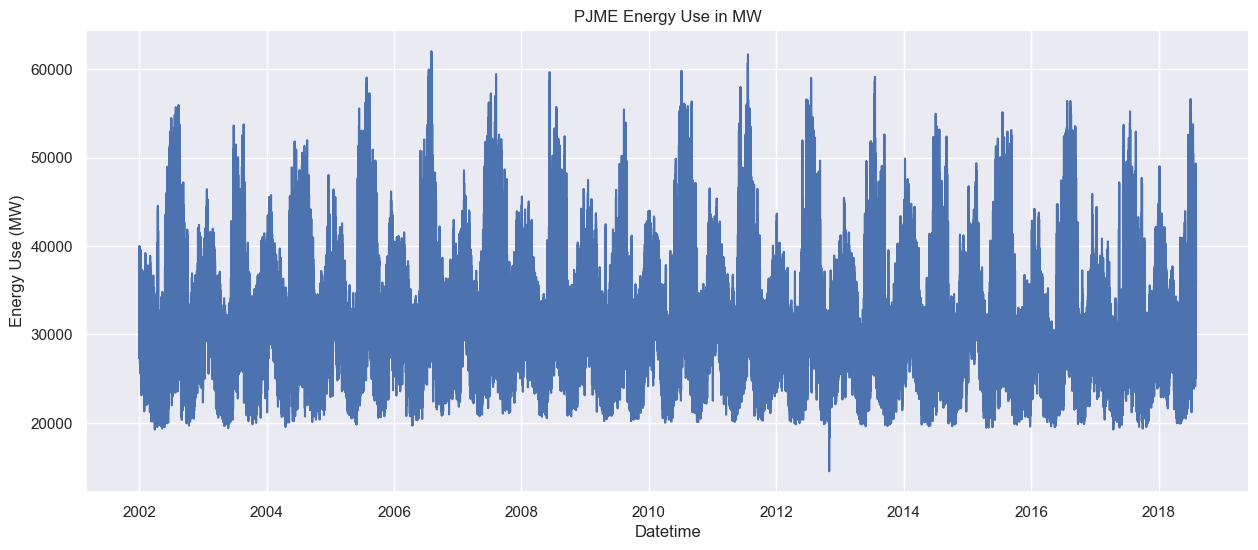

In [11]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='Datetime', y='PJME_MW', color=color_pal[0])
plt.title('PJME Energy Use in MW')
plt.xlabel('Datetime')
plt.ylabel('Energy Use (MW)')
plt.show()

### Outlier Analysis

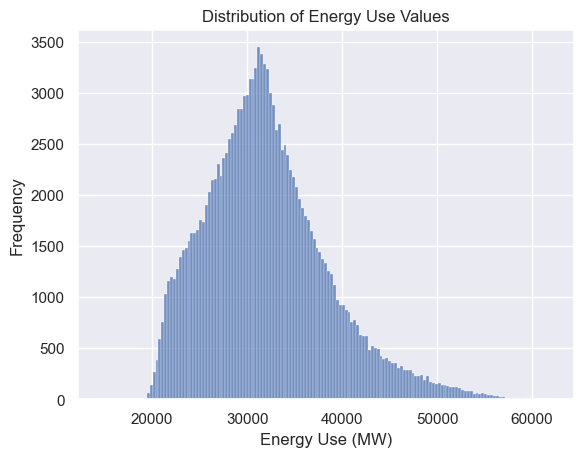

In [12]:
sns.histplot(df['PJME_MW'])
plt.title('Distribution of Energy Use Values')
plt.xlabel('Energy Use (MW)')
plt.ylabel('Frequency')
plt.show()

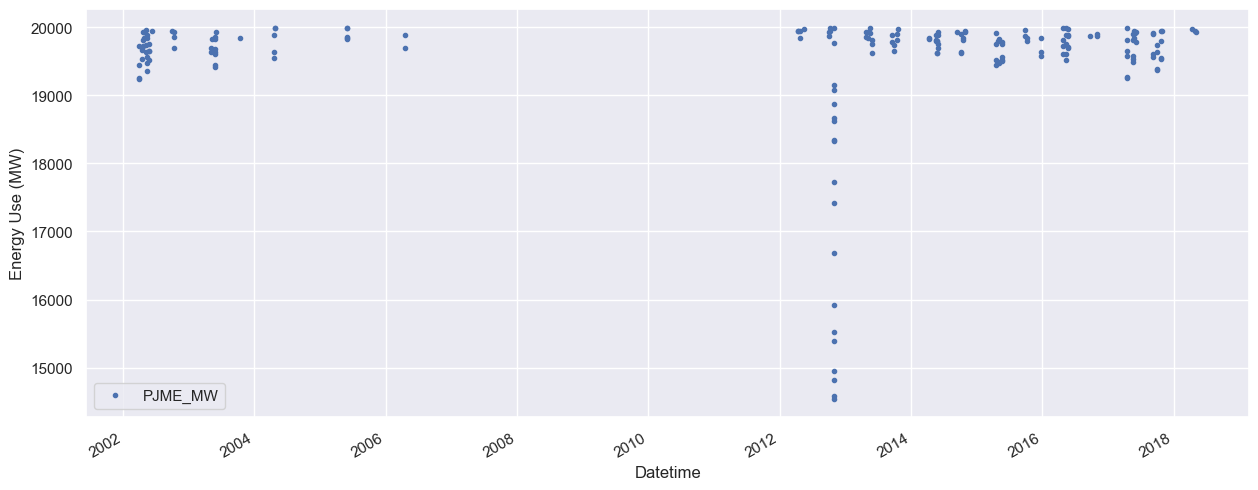

In [13]:
df.query('PJME_MW < 20000').plot(figsize=(15, 6), style='.')
plt.ylabel('Energy Use (MW)')
plt.show()

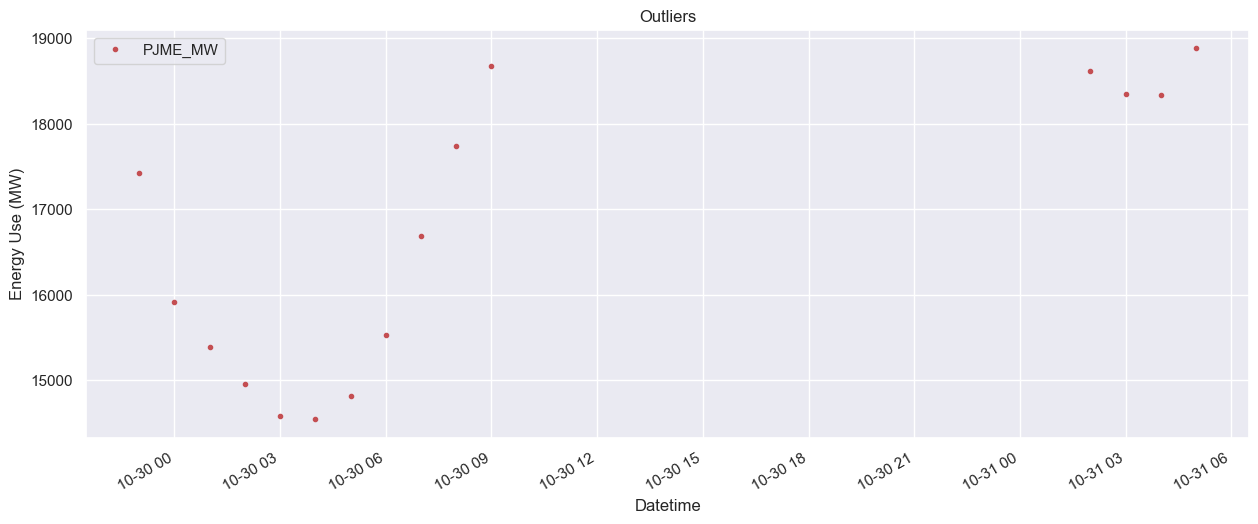

In [14]:
df.query('PJME_MW < 19000').plot(figsize=(15, 6), style='.', color=color_pal[3])
plt.title('Outliers')
plt.ylabel('Energy Use (MW)')
plt.show()

In [15]:
df = df.query('PJME_MW > 19000').copy()

### Train / Test Split

In [16]:
# train = df.loc[df.index < '2015-01-01']
# test = df.loc[df.index >= '2015-01-01']

# fig, ax = plt.subplots(figsize=(15, 6))
# train.plot(ax=ax, label='Training Set')
# test.plot(ax=ax, label='Testing Set')

# ax.axvline(pd.to_datetime('2015-01-01'), color='black', ls='--')
# ax.legend(['Training Set', 'Testing Set'])
# plt.title('PJME Energy Use in MW')
# plt.ylabel('Energy Use (MW)')
# plt.show()

In [17]:
# plt.figure(figsize=(15, 6))
# weekly_data = df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')]
# sns.lineplot(data=weekly_data, x='Datetime', y='PJME_MW')
# plt.title('A Week of PJME Energy Use in MW')
# plt.xlabel('Day')
# plt.ylabel('Energy Use (MW)')
# plt.show()

### Time-Series Cross Validation

In [18]:
from sklearn.model_selection import TimeSeriesSplit

In [20]:
# To predict hourly data for 1 year, set the test size to 365*24*1
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) # Set the gap between training and validation set being split each time
df = df.sort_index() # Sorting by index makes sure the time-series data is sorted for the tss to work

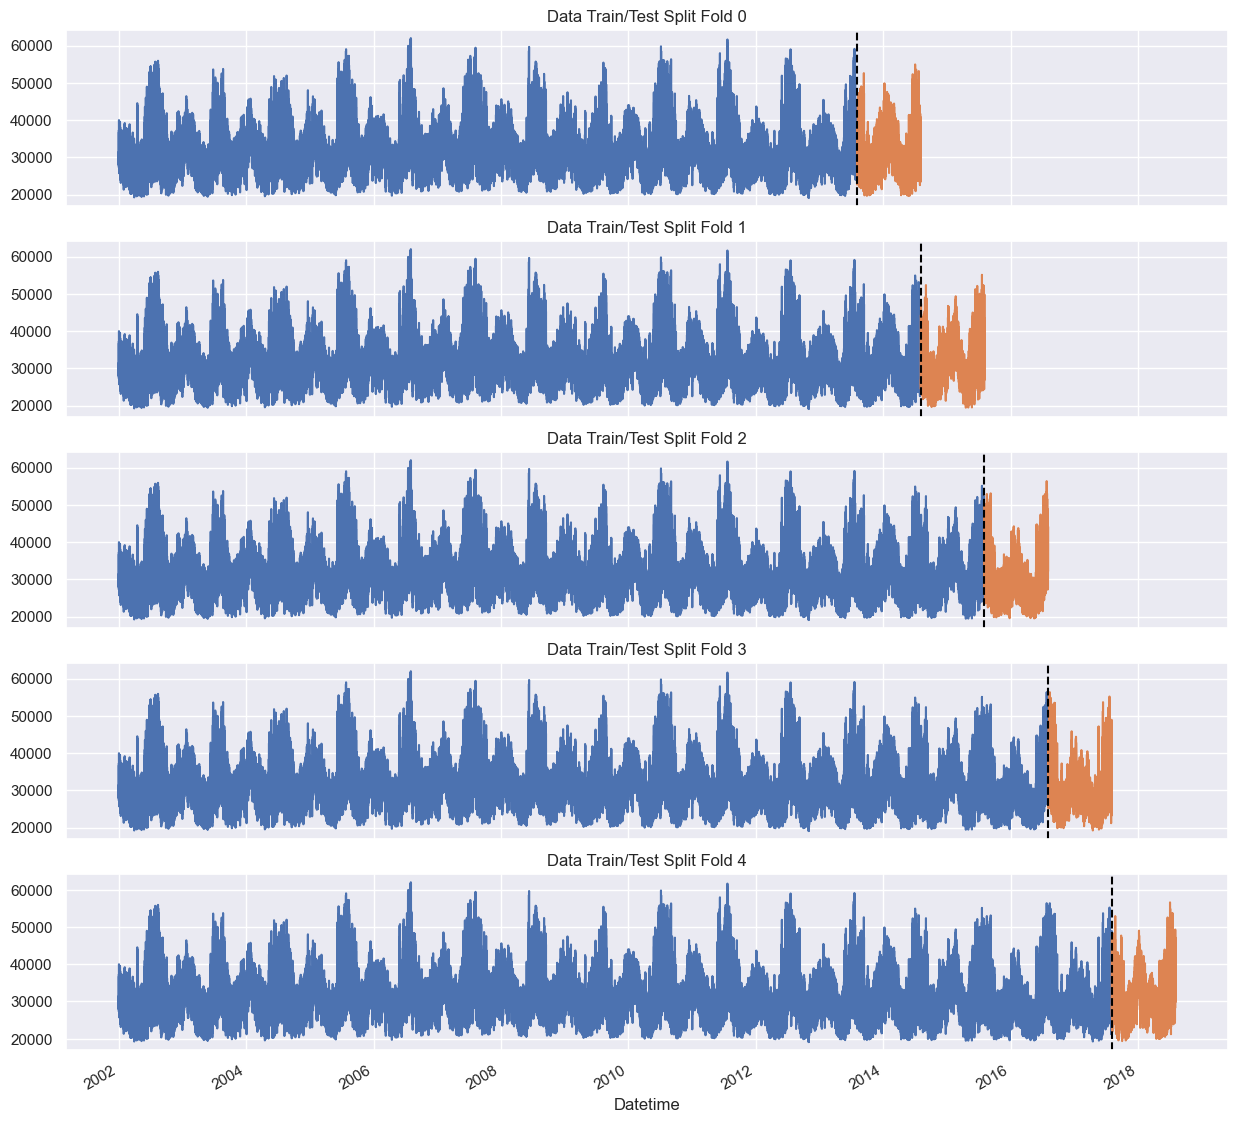

In [24]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15),
                        sharex=True)

fold = 0

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]

    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Testing Set')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--') #pd.to_datetime('2015-01-01')

    fold += 1

### Feature Engineering

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.day_of_year
    return df

df = create_features(df)
df.head()

### Visualizing Feature-Target Relationship

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='hour', y='PJME_MW')
plt.title('MW by Hour')
plt.xlabel('Hour')
plt.ylabel('Energy Use (MW)')
plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='month', y='PJME_MW')
plt.title('MW by Month')
plt.xlabel('Month')
plt.ylabel('Energy Use (MW)')
plt.show()

### Modeling

In [ ]:
train = create_features(train)
test = create_features(test)

In [ ]:
df.columns

In [ ]:
features = ['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year']
target = 'PJME_MW'

In [ ]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [ ]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

xgb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)

### Feature Importance

In [ ]:
feature_importance = pd.DataFrame(xgb_reg.feature_importances_,
                                  index=xgb_reg.feature_names_in_,
                                  columns=['importance'])

feature_importance.sort_values('importance').plot(kind='barh')
plt.title('Feature Importance')
plt.show()

### Forecasting on the Test Set

In [ ]:
test['prediction'] = xgb_reg.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)
df

In [ ]:
ax = df['PJME_MW'].plot(figsize=(15, 6))
df['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
plot1 = df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['PJME_MW'].plot()
plot2 = df.loc[(df.index > '2018-04-01') & (df.index < '2018-04-08')]['prediction'].plot()
plt.title('A Week of PJME Energy Use in MW')
plt.xlabel('Day')
plt.ylabel('Energy Use (MW)')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

### Validation

In [ ]:
xgb_score = np.sqrt(MSE(test['PJME_MW'], test['prediction']))
print(f'Test set RMSE score: {xgb_score:0.3f}')

### Calculating Error

In [ ]:
test['error'] = np.abs(test[target] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

In [ ]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head()

### Next steps
- Perform a more robust cross validation
- Add more features such as weather forecast, holidays, etc.